# Data Structuring and Pruning

In [118]:
# !pip install pathlib
from __future__ import division

In [195]:
%env DATAPATH=/util/elastic/
PAPER_SOURCES=['brca.json','cgi.json', 'civic.json', 'jax.json', 'molecularmatch.json', 'oncokb.json', 'pmkb.json']

env: DATAPATH=/util/elastic/


In [199]:
# Load datasets

import json
import pathlib
import os

data_path = pathlib.Path(os.getenv('DATAPATH','/Users/awagner/Workspace/git/g2p-aggregator/data/local/0.8'))
harvested_sources = dict()
for path in [list(data_path.glob(file))[0] for file in PAPER_SOURCES]:
    source = path.parts[-1].split('.')[0]
    with path.open() as json_data:
        # harvested_sources[source] = json.load(json_data) <- this should work, but doesn't due to malformed json
        # what follows is a hack to reassemble into proper JSON object
        associations = list()
        for line in json_data:
            associations.append(json.loads(line))
        
        # resume intended function
        harvested_sources[source] = associations

In [200]:
# Standardize structure and merge files

all_associations = list()
for source in harvested_sources:
    for entry in harvested_sources[source]:
        entry['raw'] = entry.pop(source)
        all_associations.append(entry)
        
len(all_associations)

22151

In [201]:
from collections import Counter

def report_groups(associations):
    groups = Counter()
    for association in associations:
        groups[association['source']] += 1
    total = sum(groups.values())
    for group in sorted(groups):
        print("{}: {} ({:.1f}%)".format(group, groups[group], groups[group] / len(harvested_sources[group]) * 100))
    print("Total: {} ({:.1f}%)".format(total, total / len(all_associations) * 100))

In [202]:
report_groups(all_associations)

brca: 5717 (100.0%)
cgi: 1431 (100.0%)
civic: 3497 (100.0%)
jax: 5754 (100.0%)
molecularmatch: 1104 (100.0%)
oncokb: 4048 (100.0%)
pmkb: 600 (100.0%)
Total: 22151 (100.0%)


In [203]:
# Associations with more than 1 feature
multi_featured = [x for x in all_associations if len(x['features']) > 1]
print len(multi_featured), len(all_associations)
len(multi_featured) / len(all_associations)

1991 22151


0.08988307525619611

In [204]:
report_groups(multi_featured)

cgi: 140 (9.8%)
jax: 1797 (31.2%)
molecularmatch: 19 (1.7%)
oncokb: 35 (0.9%)
Total: 1991 (9.0%)


In [205]:
# Associations with feature name lists
listed_feature_names = [x for x in all_associations if isinstance(x['feature_names'], list)]
print len(listed_feature_names), len(all_associations)
len(listed_feature_names) / len(all_associations)

0 22151


0.0

In [206]:
report_groups(listed_feature_names)

Total: 0 (0.0%)


In [207]:
len([x for x in listed_feature_names if len(x['feature_names']) >1 ])

0

## Feature coordinate filtering

What follows is a detailed look at associations without start and end coordinates after normalization, and a set of regular expression filters to separate out these associations into chunks that can be annotated with gene- or exon-level coordinates, as appropriate.

In [208]:
# Associations with coordinate features
coord_featured = list()
no_coord_featured = list()
for association in all_associations:
    c = 0
    for feature in association['features']:
        if ('start' in feature) and ('end') in feature:
            coord_featured.append(association)
            break
        else:
            c+=1
    if c == len(association['features']):
        no_coord_featured.append(association)

In [209]:
report_groups(coord_featured)

brca: 5717 (100.0%)
civic: 3497 (100.0%)
jax: 5612 (97.5%)
molecularmatch: 901 (81.6%)
oncokb: 4025 (99.4%)
pmkb: 600 (100.0%)
Total: 20352 (91.9%)


In [210]:
report_groups(no_coord_featured)

cgi: 1431 (100.0%)
jax: 142 (2.5%)
molecularmatch: 203 (18.4%)
oncokb: 23 (0.6%)
Total: 1799 (8.1%)


In [211]:
# First association has feature, but no end coord

harvested_sources['cgi'][0]['features']

[{u'alt': u'T',
  u'biomarker_type': u'mutant',
  u'chromosome': u'9',
  u'description': u'ABL1:T315I',
  u'geneSymbol': u'ABL1',
  u'links': [u'http://myvariant.info/v1/variant/chr9:g.133748283C>T?assembly=hg19',
   u'http://reg.genome.network/refseq/RS000057',
   u'http://reg.genome.network/refseq/RS000033',
   u'http://reg.genome.network/refseq/RS000009',
   u'http://reg.genome.network/refseq/RS002120',
   u'http://reg.genome.network/allele/CA122575',
   u'http://www.ncbi.nlm.nih.gov/snp/121913459',
   u'http://myvariant.info/v1/variant/chr9:g.130872896C>T?assembly=hg38',
   u'http://www.ncbi.nlm.nih.gov/clinvar/?term=27663[alleleid]',
   u'http://cancer.sanger.ac.uk/cosmic/mutation/overview?id=12560',
   u'http://www.ncbi.nlm.nih.gov/clinvar/variation/12624'],
  u'name': u'ABL1:T315I',
  u'ref': u'C',
  u'referenceName': u'GRCh37',
  u'start': 133748283,
  u'synonyms': [u'NC_000009.12:g.130872896C>T',
   u'NG_012034.1:g.164016C>T',
   u'NC_000009.11:g.133748283C>T',
   u'chr9:g.133

In [212]:
# Associations with partial coordinate features
partial_coord_featured = list()
no_partial_coord_featured = list()
for association in all_associations:
    c = 0
    for feature in association['features']:
        if ('start' in feature):
            partial_coord_featured.append(association)
            break
        else:
            c+=1
    if c == len(association['features']):
        no_partial_coord_featured.append(association)

In [213]:
report_groups(no_partial_coord_featured)

cgi: 725 (50.7%)
jax: 142 (2.5%)
molecularmatch: 203 (18.4%)
oncokb: 23 (0.6%)
Total: 1093 (4.9%)


In [214]:
def get_feature_names(associations):
    return (list(map(lambda x: x['feature_names'], associations)))
feature_names = get_feature_names(no_partial_coord_featured)

In [215]:
no_partial_coord_featured_no_feature_names = [x for x in no_partial_coord_featured if x['feature_names'] is None]
no_partial_coord_featured_with_feature_names = [x for x in no_partial_coord_featured if x['feature_names'] is not None]

In [216]:
report_groups(no_partial_coord_featured_no_feature_names)

molecularmatch: 139 (12.6%)
Total: 139 (0.6%)


In [217]:
# All of these have exactly 1 gene name

len([x['genes'] for x in no_partial_coord_featured_no_feature_names if len(x['genes']) == 1])

139

In [218]:
report_groups(no_partial_coord_featured_with_feature_names)

cgi: 725 (50.7%)
jax: 142 (2.5%)
molecularmatch: 64 (5.8%)
oncokb: 23 (0.6%)
Total: 954 (4.3%)


In [221]:
import re

def feature_filter(re_obj, associations):
    # report matches and return non-matches
    found = list(filter(lambda x: re_obj.search(x['feature_names']) is not None, associations))
    not_found = list(filter(lambda x: re_obj.search(x['feature_names']) is None, associations))
    report_groups(found)
    return(not_found, found)

amp_re = re.compile(r'(amplification)|(loss)|(amp)', re.IGNORECASE)
(remainder, found)  = feature_filter(amp_re, no_partial_coord_featured_with_feature_names)

cgi: 125 (8.7%)
molecularmatch: 4 (0.4%)
oncokb: 1 (0.0%)
Total: 130 (0.6%)


In [223]:
# print information about items that match RE. ie items that need location coordinates
print found[0]['source']
print found[0]['feature_names']
print found[0]['features'][0]
print found[0]['raw']


cgi
ALK amplification
{u'geneSymbol': u'ALK', u'referenceName': u'GRCh37', u'biomarker_type': u'amplification', u'name': u'ALK:amp', u'description': u'ALK:amp'}
{u'Targeting': u'', u'Alteration': u'ALK:amp', u'Source': u'PMID:22277784', u'cDNA': u'', u'Primary Tumor type': u'Lung adenocarcinoma', u'individual_mutation': u'', u'Drug full name': u'Crizotinib (ALK inhibitor)', u'Association': u'Resistant', u'Drug family': u'ALK inhibitor', u'Biomarker': u'ALK amplification', u'Drug': u'Crizotinib', u'Curator': u'RDientsmann', u'gDNA': u'', u'Drug status': u'', u'Gene': u'ALK', u'transcript': u'', u'strand': u'', u'info': u'', u'Assay type': u'', u'Alteration type': u'CNA', u'region': u'', u'Evidence level': u'Case report', u'Primary Tumor acronym': u'LUAD', u'Metastatic Tumor Type': u''}


In [224]:
fusion_re = re.compile(r'(\w{2,}-\w{2,})|(fusion)', re.IGNORECASE)
(r2, found) = feature_filter(fusion_re, remainder)
print found[0]['source']
print found[0]['feature_names']
print found[0]['features'][0]
print found[0]['raw']


cgi: 117 (8.2%)
jax: 101 (1.8%)
molecularmatch: 49 (4.4%)
oncokb: 5 (0.1%)
Total: 272 (1.2%)
cgi
ABL1-BCR fusion
{u'geneSymbol': u'ABL1', u'referenceName': u'GRCh37', u'biomarker_type': u'splice', u'name': u'ABL1__BCR', u'description': u'ABL1__BCR'}
{u'Targeting': u'', u'Alteration': u'ABL1__BCR', u'Source': u'EMA', u'cDNA': u'', u'Primary Tumor type': u'Chronic myeloid leukemia;Acute lymphoblastic leukemia', u'individual_mutation': u'', u'Drug full name': u'Imatinib (BCR-ABL inhibitor 1st gen&KIT inhibitor)', u'Association': u'Responsive', u'Drug family': u'BCR-ABL inhibitor 1st gen&KIT inhibitor', u'Biomarker': u'ABL1-BCR fusion', u'Drug': u'Imatinib', u'Curator': u'CRubio-Perez;DTamborero;RDientsmann', u'gDNA': u'', u'Drug status': u'Approved', u'Gene': u'ABL1', u'transcript': u'', u'strand': u'', u'info': u'', u'Assay type': u'', u'Alteration type': u'FUS', u'region': u'', u'Evidence level': u'FDA guidelines', u'Primary Tumor acronym': u'CML;ALL', u'Metastatic Tumor Type': u''}


In [228]:
ppm_re = re.compile(r'\w+(:| )[a-z]\d+[a-z]?(fs\*?)?$', re.IGNORECASE)
(r3, found) = feature_filter(ppm_re, r2)


jax: 5 (0.1%)
oncokb: 13 (0.3%)
Total: 18 (0.1%)


In [229]:
# utility to generate curl commands

def test_curls(associations):
    names = []
    for a in associations:
        for f in a['features']:
            names.append(tuple(f['name'].strip().split(' ')))
    names = list(set(names))
    print '# curl commands to find feature location'
    for t in names:
        if len(t) > 1:
            print "curl -s 'http://myvariant.info/v1/query?q={}%20{}'  | jq '.hits[0] | {{name: \"{} {}\", referenceName: \"GRCh37\", chromosome: .chrom, start: .hg19.start, end: .hg19.end, ref: .vcf.ref, alt: .vcf.alt }}'".format(t[0],t[1], t[0],t[1])

test_curls(found)            

# curl commands to find feature
curl -s 'http://myvariant.info/v1/query?q=SMO%20E518K'  | jq '.hits[0] | {name: "SMO E518K", referenceName: "GRCh37", chromosome: .chrom, start: .hg19.start, end: .hg19.end, ref: .vcf.ref, alt: .vcf.alt }'


In [231]:
indel_re = re.compile(r'\w+(:| )\w+(ins\w+)|(del($|ins\w+))|(dup$)')
(r4, found) = feature_filter(indel_re, r3)

jax: 27 (0.5%)
Total: 27 (0.1%)


In [232]:
bucket_re = re.compile(r'[A-Z0-9]+( (in)?act)?( oncogenic)? mut((ant)|(ation))?$')
(r5,found) = feature_filter(bucket_re, r4)

cgi: 183 (12.8%)
Total: 183 (0.8%)


In [233]:
exon_re = re.compile(r'exon', re.IGNORECASE)
(r6,found) = feature_filter(exon_re, r5)

cgi: 36 (2.5%)
oncokb: 4 (0.1%)
Total: 40 (0.2%)


In [234]:
expression_re = re.compile(r'(exp)|(^\w+ (pos(itive)?)|(neg(ative)?)|(biallelic inactivation)$)|(truncating)|(deletion)', re.IGNORECASE)
(r7, found) = feature_filter(expression_re, r6)

cgi: 172 (12.0%)
Total: 172 (0.8%)


In [235]:
report_groups(r7)

cgi: 92 (6.4%)
jax: 9 (0.2%)
molecularmatch: 11 (1.0%)
Total: 112 (0.5%)


In [236]:
get_feature_names([x for x in r7 if x['source'] == 'cgi'])

[u'ABL1 (I242T,M244V,K247R,L248V,G250E,G250R,Q252R,Q252H,Y253F,Y253H,E255K,E255V,M237V,E258D,W261L,L273M,E275K,E275Q,D276G,T277A,E279K,V280A,V289A,V289I,E292V,E292Q,I293V,L298V,V299L,F311L,F311I,T315I,F317L,F317V,F317I,F317C,Y320C,L324Q,Y342H,M343T,A344V,A350V,M351T,E355D,E355G,E355A,F359V,F359I,F359C,F359L,D363Y,L364I,A365V,A366G,L370P,V371A,E373K,V379I,A380T,F382L,L384M,L387M,L387F,L387V,M388L,Y393C,H396P,H396R,H396A,A397P,S417F,S417Y,I418S,I418V,A433T,S438C,E450K,E450G,E450A,E450V,E453K,E453G,E453A,E453V,E459K,E459G,E459A,E459V,M472I,P480L,F486S,E507G)',
 u'BRAF (K601R,L597R,V600R)',
 u'BRAF (V600R)',
 u'BRAF (V600D,V600K,V600M,V600G,V600R)',
 u'CSF3R frameshift variant (D771),frameshift variant (S783)',
 u'DPYD splice donor variant',
 u'BRAF (V600)',
 u'BRAF (V600)',
 u'BRAF (V600E,V600D,V600K,V600M,V600G,V600R)',
 u'BRAF (V600E,V600D,V600K,V600M,V600G,V600R)',
 u'BTK (C481)',
 u'EGFR (S720)',
 u'EGFR (L718)',
 u'ERBB4 (H809G)',
 u'FLT3 (D835)',
 u'FLT3 (N676)',
 u'FLT3 (D835,Y842)

# Knowledgebase Comparison

## Genes

In [237]:
from collections import defaultdict

def genes_by_source(associations):
    source_genes = defaultdict(set)
    for association in associations:
        source_genes[association['source']].update(association['genes'])
    return source_genes

In [238]:
s = genes_by_source(all_associations)

In [239]:
import pyupset as pyu
import pandas as pd
%matplotlib inline

def plot_overlap(set_dict):
    d = {g: pd.DataFrame(list(set_dict[g])) for g in set_dict}
    pyu.plot(d, inters_size_bounds=(3, 400000))

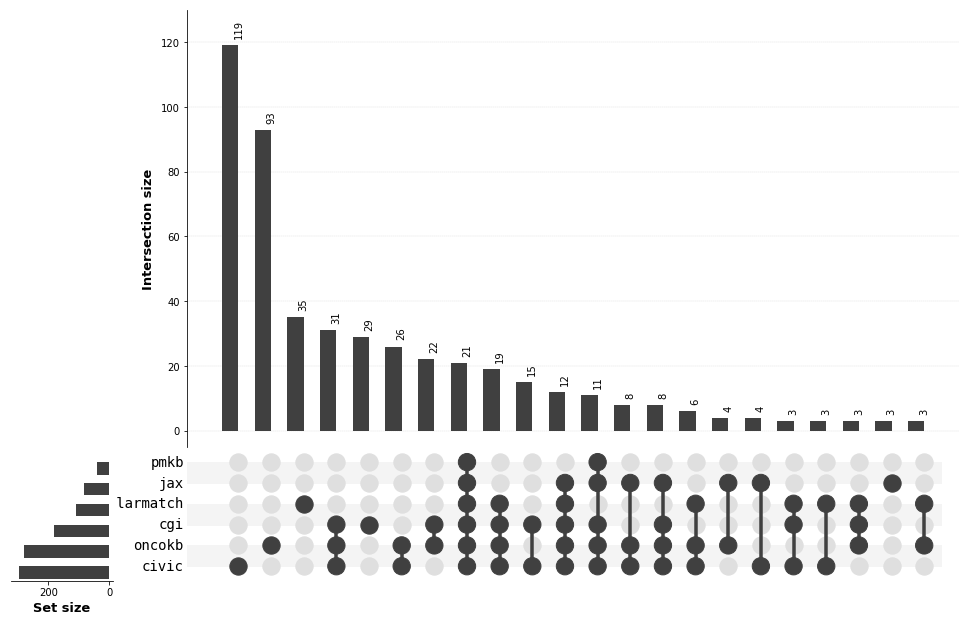

In [240]:
# omitting BRCA (only 2 genes)
s = {k: v for k, v in s.items() if k != 'brca'}
plot_overlap(s)

In [165]:
# Genes observed in all knowledgebases
